# Extract data from databases behind a website

Websites, particularly dashboards, call out to APIs to create their live graphics.
If you open Developer mode on Chrome or Firefox, you can see the calls, and adapt them to extract data from the same APIs.

E.g. Lets look at http://staging.globalforestwatch.org/countries/BRA

In [1]:
import requests
import pandas as pd
%matplotlib inline

You can see for example how it gets its Fire data via calling to the following URL.

In [2]:
url = "https://production-api.globalforestwatch.org/v1/viirs-active-fires/admin/BRA?period=2017-06-17,2017-06-24"
r = requests.get(url)
r.status_code
data = r.json()

In [3]:
data

{'data': {'attributes': {'areaHa': 855189203.6641197,
   'downloadUrls': {'csv': "https://wri-01.cartodb.com/api/v2/sql?q=with%20p%20as%20(SELECT%20%20the_geom%0A%20%20%20%20%20%20%20%20%20%20%20FROM%20gadm2_countries_simple%0A%20%20%20%20%20%20%20%20%20%20%20WHERE%20iso%20%3D%20UPPER('BRA'))%0A%20%20%20%20%20%20%20%20%20%20%20%20SELECT%20pt.*%0A%20%20%20%20%20%20%20%20%20%20%20%20FROM%20p%0A%20%20%20%20%20%20%20%20%20%20%20%20inner%20join%20vnp14imgtdl_nrt_global_7d%20pt%20on%20ST_Intersects(p.the_geom%2C%20pt.the_geom)%0A%20%20%20%20%20%20%20%20%20%20%20%20and%0A%20%20%20%20%20%20%20%20%20%20%20%20%20confidence%3D'nominal'%20AND%20acq_date%20%3E%3D%20'2017-06-17'%3A%3Adate%0A%20%20%20%20%20%20%20%20%20%20%20%20%20AND%20acq_date%20%3C%3D%20'2017-06-24'%3A%3Adate&format=csv",
    'geojson': "https://wri-01.cartodb.com/api/v2/sql?q=with%20p%20as%20(SELECT%20%20the_geom%0A%20%20%20%20%20%20%20%20%20%20%20FROM%20gadm2_countries_simple%0A%20%20%20%20%20%20%20%20%20%20%20WHERE%20iso%20%3D%2

When you extract the data in JSON it acts as a regular python dictionary. Easy for you to access and extract the data:

In [4]:
type(data)

dict

In [5]:
area = data.get('data').get('attributes').get('areaHa')
number_of_fires = data.get('data').get('attributes').get('value')
period = data.get('data').get('attributes').get('period')

print(f"There were {number_of_fires:,g} fire events detected, "
      f"over an area of {int(area):6,.0f} Ha in the {period.lower()}.")

There were 9,316 fire events detected, over an area of 855,189,203 Ha in the past week.


## Slightly more complicated now

#### An example of how the SQL can be treated as a header

Usually, the API is connecting a database, and the database query is embedded directly in the URL. For example, you can see in that website there are many time series figures being produced. 

Let's see how to from an SQL request embeddeded in a URL to a useable dataframe in Pandas!

In [6]:
url_base =  "https://production-api.globalforestwatch.org/v1/query"
sql = "SELECT count(*) as alerts FROM e663eb09-04de-4f39-b871-35c6c2ed10b5 GROUP BY julian_day, year ORDER BY year, julian_day"

r = requests.get(url_base, {'sql':sql})
print(r.status_code)
print(r.url)

200
https://production-api.globalforestwatch.org/v1/query?sql=SELECT+count%28%2A%29+as+alerts+FROM+e663eb09-04de-4f39-b871-35c6c2ed10b5+GROUP+BY+julian_day%2C+year+ORDER+BY+year%2C+julian_day


In [7]:
data = r.json()

In [8]:
data.get('data')

[{'alerts': 15391, 'julian_day': 1, 'year': 2015},
 {'alerts': 140355, 'julian_day': 1, 'year': 2016},
 {'alerts': 126526, 'julian_day': 1, 'year': 2017},
 {'alerts': 93974, 'julian_day': 2, 'year': 2015},
 {'alerts': 503675, 'julian_day': 2, 'year': 2016},
 {'alerts': 148719, 'julian_day': 2, 'year': 2017},
 {'alerts': 67812, 'julian_day': 3, 'year': 2015},
 {'alerts': 266849, 'julian_day': 3, 'year': 2016},
 {'alerts': 90772, 'julian_day': 3, 'year': 2017},
 {'alerts': 62020, 'julian_day': 4, 'year': 2015},
 {'alerts': 363674, 'julian_day': 4, 'year': 2016},
 {'alerts': 37728, 'julian_day': 4, 'year': 2017},
 {'alerts': 40606, 'julian_day': 5, 'year': 2015},
 {'alerts': 131522, 'julian_day': 5, 'year': 2016},
 {'alerts': 124366, 'julian_day': 5, 'year': 2017},
 {'alerts': 180484, 'julian_day': 6, 'year': 2015},
 {'alerts': 129899, 'julian_day': 6, 'year': 2016},
 {'alerts': 314504, 'julian_day': 6, 'year': 2017},
 {'alerts': 148757, 'julian_day': 7, 'year': 2015},
 {'alerts': 206849,

In [9]:
base_frame = []
for row in data.get('data'):
    tmp = []
    tmp.append(row.get('year'))
    tmp.append(row.get('julian_day'))
    tmp.append(row.get('alerts'))
    base_frame.append(tmp)
    
df = pd.DataFrame(base_frame, columns=['year','julian_day', 'alerts'])

In [10]:
df.head()

,year,julian_day,alerts
0,2015,1,15391
1,2016,1,140355
2,2017,1,126526
3,2015,2,93974
4,2016,2,503675


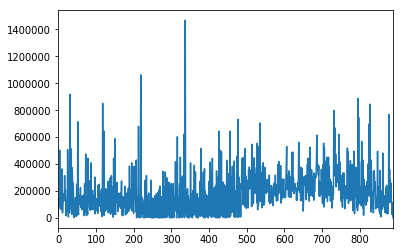

In [11]:
df['alerts'].plot()

In [12]:
df.julian_day

0        1
1        1
2        1
3        2
4        2
5        2
6        3
7        3
8        3
9        4
10       4
11       4
12       5
13       5
14       5
15       6
16       6
17       6
18       7
19       7
20       7
21       8
22       8
23       8
24       9
25       9
26       9
27      10
28      10
29      10
      ... 
859    351
860    351
861    352
862    352
863    353
864    353
865    354
866    354
867    355
868    355
869    356
870    356
871    357
872    357
873    358
874    358
875    359
876    359
877    360
878    360
879    361
880    361
881    362
882    362
883    363
884    363
885    364
886    364
887    365
888    365
Name: julian_day, Length: 889, dtype: int64

In [13]:
import maya

In [55]:
date_index = []
for y,doy in zip(df.year, df.julian_day):
    tmp = maya.parse(f'{y}-01-01')
    tmp.add(days=int(doy))
    date_index.append(tmp.datetime())

In [57]:
df.index = date_index

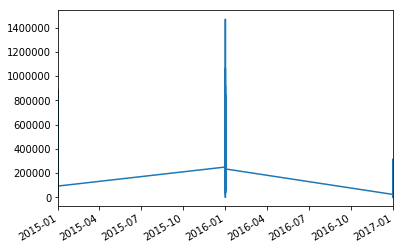

In [58]:
df.alerts.plot()

In [49]:
print(tmp.datetime().date())

2016-01-01
